**Hospitality Employees Time Series Data Forecasting**

 This is a time series forecasting application project based off of the dataset on [Hospitality Employees - Time Series Dataset on Kaggle](https://www.kaggle.com/datasets/gabrielsantello/hospitality-employees-time-series-dataset).

---




- With this data we can track employement figures in the hospitality industry
over time, with a date and emplyees count value per period.


- The dataset is univariete and has only two columns (1) Date: Timestamp, monthly (2) Employees : Number of employees  in thousand

- The data spans over several years from 1990-2018, this makes it a good subject for trend and seasonal analysis


**First step we can import the relevant libraries for model development and data manipulation**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf


**Now we download the dataset using the Kaggle API**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevonbvunza","key":"911b1c56c8b0ace673aeb2d85f9bd835"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gabrielsantello/hospitality-employees-time-series-dataset


Dataset URL: https://www.kaggle.com/datasets/gabrielsantello/hospitality-employees-time-series-dataset
License(s): CC0-1.0
hospitality-employees-time-series-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


**Next initiate a dataframe and store it in the df variable, store the date column as the index after parsing the date and time. as we can see it follows a month start cadence**

In [ ]:
df = pd.read_csv('/content/hospitality-employees-time-series-dataset.zip', parse_dates=['Date'], index_col='Date')
df


,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7
...,...
2018-08-01,2019.1
2018-09-01,1992.5
2018-10-01,1984.3


In [ ]:
df.describe()

,Employees
count,348.000000
mean,1452.506897
std,256.604914
min,1064.500000
25%,1238.050000
50%,1436.200000
75%,1586.300000
max,2022.100000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1990-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Employees  348 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


**For visualization purposes we will now plot the data against time on the x-axis**

<Axes: xlabel='Date'>

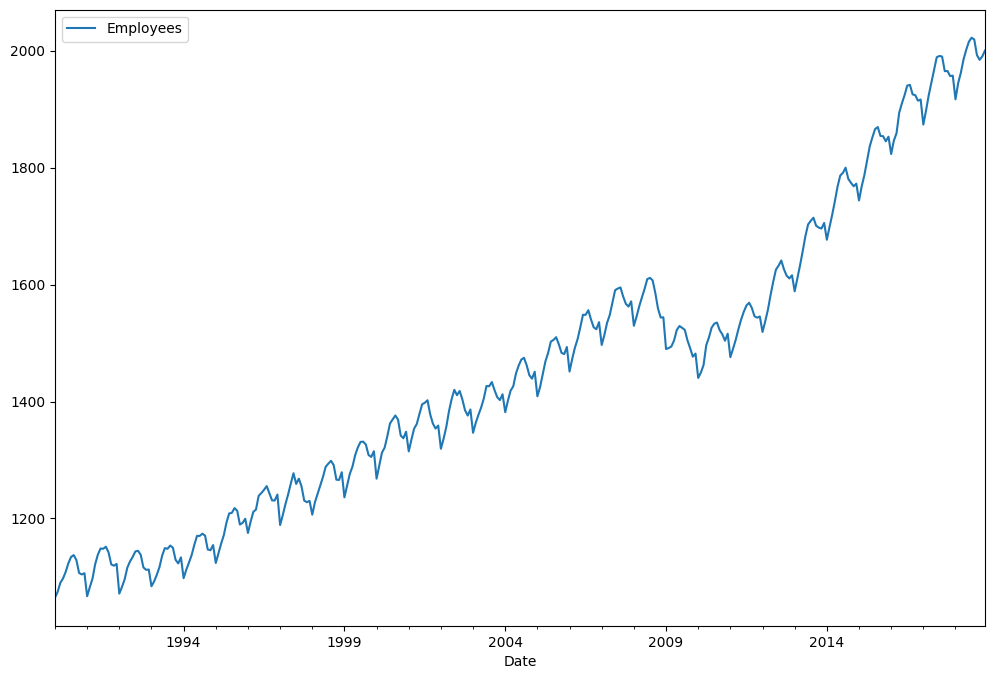

In [ ]:
df.plot(figsize=(12,8))

**Now the follwing steps are taken to decide the start of the test index.**

In [ ]:
len(df)

348

In [ ]:
test_size = 24 # this leaves 2 years to prediction and testing
test_index= len(df)-test_size

In [ ]:
train= df.iloc[:test_index]
test= df.iloc[test_index:]

In [ ]:
len(train)

324

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)


scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
len(test)

24

**The train test split was done successfully with 300 train samples and 48 test samples, now the scalling needs to be done.WE have selected a MInMax Scaler for ths purpose**

In [ ]:
from tensorflow.keras.utils import timeseries_dataset_from_array

length = 12
batch_size =1
n_features = 1

In [ ]:
generated_batches = timeseries_dataset_from_array(  data = scaled_train,
                                                    targets = scaled_train,
                                                    sequence_length = length,
                                                    batch_size = batch_size
                                                  )

In [ ]:
validation_generated_batches = timeseries_dataset_from_array(data= scaled_test,
                                                             targets= scaled_test,
                                                             sequence_length = length,
                                                             batch_size=1)

In [ ]:
for X, y in generated_batches.take(1):
    print(X.shape, y.shape)

(1, 12, 1) (1, 1)


In [ ]:
print(X)

tf.Tensor(
[[[0.        ]
  [0.01140251]
  [0.0290764 ]
  [0.03751425]
  [0.05039909]
  [0.0672748 ]
  [0.07947548]
  [0.08312429]
  [0.07331813]
  [0.04823261]
  [0.04538198]
  [0.04777651]]], shape=(1, 12, 1), dtype=float64)


In [ ]:
print(y)

tf.Tensor([[0.]], shape=(1, 1), dtype=float64)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN,GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience= 5)

**Implementation of the Long Short Term Memory RNN**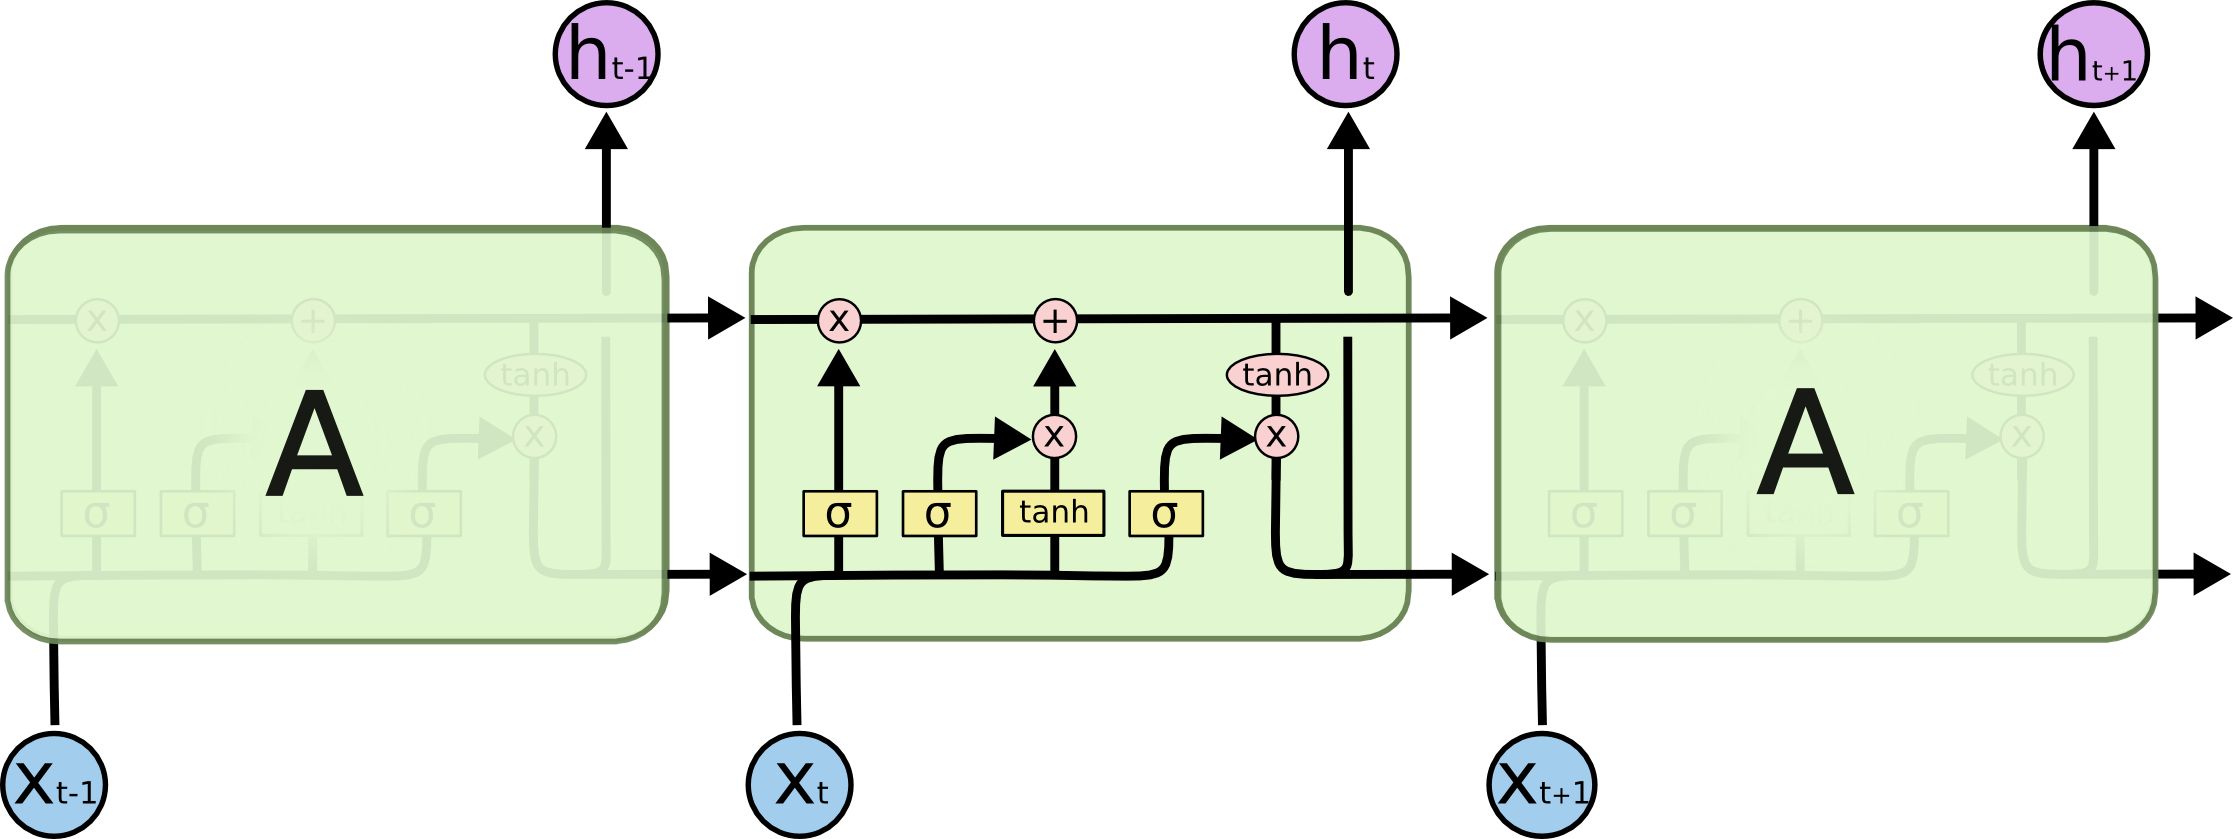

In [ ]:
model_LSTM =Sequential()

model_LSTM.add(LSTM(units = 150 , activation= 'relu', input_shape=(length, n_features)))


model_LSTM.add(Dense(1))

model_LSTM.compile(optimizer ='adam', loss= 'mse')

model_LSTM.fit( generated_batches,
                epochs =30 ,
                validation_data=validation_generated_batches,
                callbacks=[early_stop,checkpoint]
              )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
Epoch 1: val_loss did not improve from 0.00183
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093
Epoch 2: val_loss did not improve from 0.00183
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0067
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 3: val_loss did not improve from 0.00183
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0101
Epoch 4: val_loss did not improve from 0.00183
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0100 - val_loss: 0.0084
Epoch 5/30
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0097
Epoch 5: val_loss did not improve from 0.00183
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 6/30
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1

<Axes: >

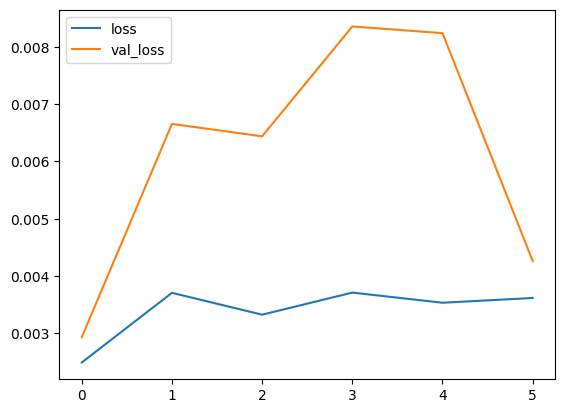

In [ ]:
losses_LSTM = pd.DataFrame(model_LSTM.history.history)
losses_LSTM.plot()


In [ ]:
model_LSTM.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,055 (1.05 MB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 182,704 (713.69 KB)

**Evaluation**

**First Section**

This works on generating predictions from predictions. The loop below drops the oldest value from the timeseries , and append the new predicted value. Thus we see that the model tends to deviate further from the test data as longer sequences are predicted

In [ ]:

# make a list to hold new test predictions
test_predictions= []

# start on the last window in the train set
first_eval_batch= scaled_train[-length:]

# reshape the data in the first batch into data acceptable by the RNN (batch_size, length, n_features)
current_batch= first_eval_batch.reshape(1, length, n_features)

for i in range(len(test)):
    #get 1 prediction a single timestep ahead
    current_pred= model_LSTM.predict(current_batch)[0]

    #add the new prediction to the test predictions list
    test_predictions.append(current_pred)

    current_pred = current_pred.reshape((1, 1, n_features))



   # now drop the oldest value in the timeseries and concatenate with the new test prediction
    current_batch= np.concatenate((current_batch[:, 1:, :],current_pred), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


**Second Section**

This is when I compared the predictions from the test data and derived an Mean Square Error calculation.

/tmp/ipython-input-1675350303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM prediction']= true_predictions


<Axes: xlabel='Date'>

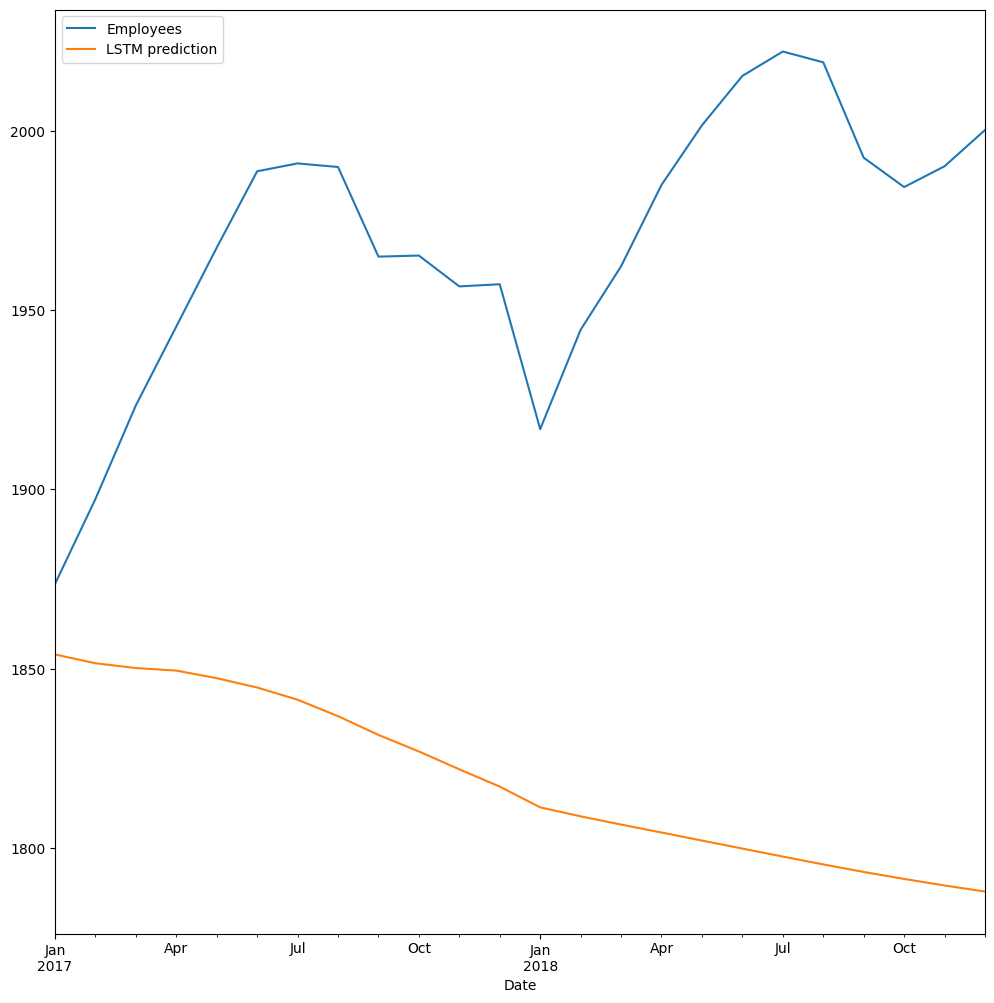

In [ ]:
true_predictions =scaler.inverse_transform(test_predictions)

test['LSTM prediction']= true_predictions

test.plot(figsize=(12,12))

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print(np.sqrt(mean_squared_error(test['Employees'], test['LSTM prediction'])))

159.15543936262415


In [ ]:
deviation = (np.sqrt(mean_squared_error(test['Employees'], test['LSTM prediction']))/df['Employees'].mean())*100
print(f" The model has an average deviation of {round(deviation,2)}% relative to the mean employee count")

 The model has an average deviation of 10.96% relative to the mean employee count


 ## The model has an average deviation of 10.96% relative to the mean employee count. Therefore, the model is suitable for forecasting usecases.
